In [1]:
pip install wilds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.3 MB/s eta 0:00:00


In [2]:
pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=cae72fafc109564946bc494c1e168a88e445d2454a3110c052b3adcdddf8e6e9
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [3]:
import time
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 20
KD_TEMPERATURE = 4.0
KD_ALPHA = 0.5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epsilon = 0.01  # Perturbation magnitude

dataset = get_dataset(dataset="waterbirds", download=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = dataset.get_subset("train", transform=transform)
val_data = dataset.get_subset("val", transform=transform)
test_data = dataset.get_subset("test", transform=transform)

train_loader = get_train_loader("standard", train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

metadata_array = test_data.metadata_array
bird_type_idx = dataset.metadata_fields.index('y')
background_idx = dataset.metadata_fields.index('background')

bird_type = metadata_array[:, bird_type_idx]
background = metadata_array[:, background_idx]

id_mask = ((bird_type == 0) & (background == 0)) | ((bird_type == 1) & (background == 1))
id_indices = torch.where(id_mask)[0]
id_data = torch.utils.data.Subset(test_data, id_indices)
id_loader = DataLoader(id_data, batch_size=BATCH_SIZE, shuffle=False)

ood_mask = ((bird_type == 0) & (background == 1)) | ((bird_type == 1) & (background == 0))
ood_indices = torch.where(ood_mask)[0]
ood_data = torch.utils.data.Subset(test_data, ood_indices)
ood_loader = DataLoader(ood_data, batch_size=BATCH_SIZE, shuffle=False)

teacher_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=False)
teacher_model.fc = nn.Linear(2048, 2)
teacher_model = teacher_model.to(DEVICE)

# Student model: ResNet18
student_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet18', pretrained=False)
student_model.fc = nn.Linear(512, 2)
student_model = student_model.to(DEVICE)

ce_criterion = nn.CrossEntropyLoss()

def kd_loss_fn(student_logits, teacher_logits, temperature=KD_TEMPERATURE):
    teacher_probs = torch.softmax(teacher_logits / temperature, dim=1)
    student_log_probs = torch.log_softmax(student_logits / temperature, dim=1)
    kl_div = torch.sum(teacher_probs * (torch.log(teacher_probs) - student_log_probs), dim=1).mean()
    return kl_div * (temperature**2)

def generate_adversarial_color_perturbation(model, images, labels, epsilon=0.01):
    """
    Generates adversarial perturbations constrained to color channels.
    Args:
        model: The model being trained.
        images: Input images (batch).
        labels: Corresponding labels.
        epsilon: Perturbation magnitude.
    Returns:
        Perturbed images.
    """
    images.requires_grad = True
    outputs = model(images)
    loss = ce_criterion(outputs, labels)
    model.zero_grad()
    loss.backward()

    color_perturbation = epsilon * images.grad.sign()
    adversarial_images = images + color_perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1) 
    return adversarial_images

def adversarial_loss(student_outputs, teacher_outputs, labels, adversarial_images, alpha=0.5, temperature=4.0):
    """
    Combines standard loss with adversarial training loss.
    Args:
        student_outputs: Outputs of the student model.
        teacher_outputs: Outputs of the teacher model.
        labels: True labels.
        adversarial_images: Adversarially perturbed images.
        alpha: Weighting factor for adversarial loss.
        temperature: Knowledge distillation temperature.
    Returns:
        Combined loss.
    """
    ce_loss = ce_criterion(student_outputs, labels)

    kd_loss_value = KD_ALPHA * nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                              F.softmax(teacher_outputs / temperature, dim=1))
    standard_loss = (1 - KD_ALPHA) * ce_loss + kd_loss_value

    adversarial_outputs = student_model(adversarial_images)
    adv_loss = ce_criterion(adversarial_outputs, labels)

    return (1 - alpha) * standard_loss + alpha * adv_loss

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


489291776Byte [00:12, 39059158.47Byte/s]


Extracting data/waterbirds_v1.0/archive.tar.gz to data/waterbirds_v1.0

It took 0.3 minutes to download and uncompress the dataset.



Downloading: "https://github.com/pytorch/vision/zipball/v0.13.0" to /root/.cache/torch/hub/v0.13.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


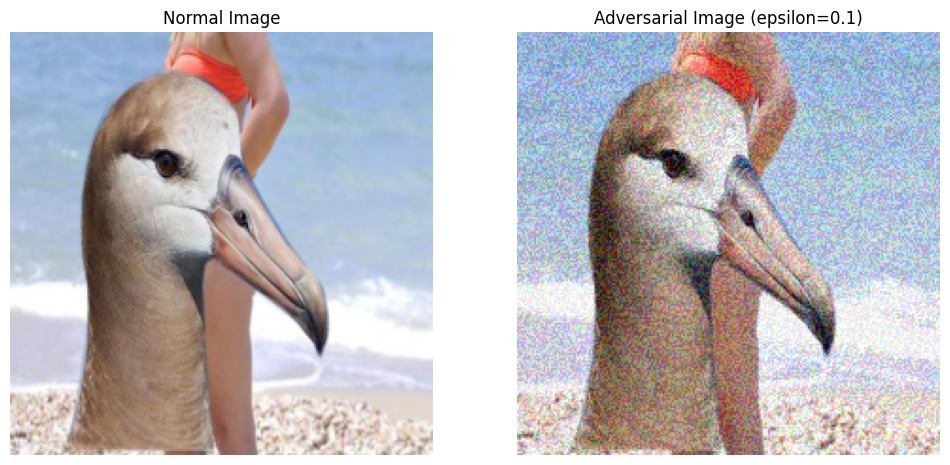

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np


def display_images(normal_image, adversarial_image, epsilon=0.1):
    """
    Displays the normal image and the adversarially perturbed image side by side.

    :param normal_image: The original image tensor
    :param adversarial_image: The adversarially perturbed image tensor
    :param epsilon: Perturbation magnitude (used if adversarial images are generated)
    """
    # Detach tensors from the computation graph and convert to numpy
    normal_image = normal_image.detach().cpu().numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    adversarial_image = adversarial_image.detach().cpu().numpy().transpose((1, 2, 0))  # Same transformation

    # Normalize the image values to [0, 1] if they are in the range [0, 255] or [-1, 1]
    normal_image = np.clip(normal_image, 0, 1)
    adversarial_image = np.clip(adversarial_image, 0, 1)

    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(normal_image)
    axes[0].set_title('Normal Image')
    axes[0].axis('off')  # Hide axes for better visualization

    axes[1].imshow(adversarial_image)
    axes[1].set_title(f'Adversarial Image (epsilon={epsilon})')
    axes[1].axis('off')  # Hide axes for better visualization

    plt.show()

# Example usage:
# Assuming 'x' is a batch from your DataLoader
# and 'generate_adversarial_color_perturbation' is already defined

x, y, _ = next(iter(test_loader))  # Just for example, take one batch from your DataLoader
x, y = x.to(DEVICE), y.to(DEVICE)

# Generate adversarial images for the batch
adversarial_images = generate_adversarial_color_perturbation(teacher_model, x, y, epsilon=0.1)

# Select one sample (image) from the batch to display
normal_image = x[0]  # The first image from the batch
adversarial_image = adversarial_images[0]  # The corresponding adversarial image

# Display the images
display_images(normal_image, adversarial_image, epsilon=0.1)


In [4]:
#######################
# Training Loop for Teacher
#######################
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=LR)
best_teacher_val_acc = 0.0

teacher_start_time = time.time()
print("Training Teacher Model...")
for epoch in range(EPOCHS):
    teacher_model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y, _ = batch
        x, y = x.to(DEVICE), y.to(DEVICE)

        teacher_logits = teacher_model(x)
        loss = ce_criterion(teacher_logits, y)

        teacher_optimizer.zero_grad()
        loss.backward()
        teacher_optimizer.step()

        total_loss += loss.item() * x.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Teacher Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_train_loss:.4f}")

    teacher_model.eval()
    correct_val = 0
    with torch.no_grad():
        for x_val, y_val, _ in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
            logits_val = teacher_model(x_val)
            preds_val = torch.argmax(logits_val, dim=1)
            correct_val += (preds_val == y_val).sum().item()
    val_acc = correct_val / len(val_loader.dataset)
    print(f"Teacher Validation Accuracy: {val_acc*100:.2f}%")

    if val_acc > best_teacher_val_acc:
        best_teacher_val_acc = val_acc
        os.makedirs('models', exist_ok=True)
        torch.save(teacher_model.state_dict(), 'models/teacher_resnet50.pt')

Training Teacher Model...


Epoch 1/20: 100%|██████████| 150/150 [01:08<00:00,  2.18it/s]


Teacher Epoch [1/20] - Loss: 0.3983
Teacher Validation Accuracy: 63.39%


Epoch 2/20: 100%|██████████| 150/150 [01:02<00:00,  2.40it/s]


Teacher Epoch [2/20] - Loss: 0.3305
Teacher Validation Accuracy: 51.04%


Epoch 3/20: 100%|██████████| 150/150 [01:03<00:00,  2.36it/s]


Teacher Epoch [3/20] - Loss: 0.3078
Teacher Validation Accuracy: 61.72%


Epoch 4/20: 100%|██████████| 150/150 [01:04<00:00,  2.32it/s]


Teacher Epoch [4/20] - Loss: 0.2845
Teacher Validation Accuracy: 61.63%


Epoch 5/20: 100%|██████████| 150/150 [01:04<00:00,  2.31it/s]


Teacher Epoch [5/20] - Loss: 0.2896
Teacher Validation Accuracy: 73.89%


Epoch 6/20: 100%|██████████| 150/150 [01:05<00:00,  2.30it/s]


Teacher Epoch [6/20] - Loss: 0.2837
Teacher Validation Accuracy: 59.30%


Epoch 7/20: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]


Teacher Epoch [7/20] - Loss: 0.2689
Teacher Validation Accuracy: 59.22%


Epoch 8/20: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]


Teacher Epoch [8/20] - Loss: 0.2586
Teacher Validation Accuracy: 51.79%


Epoch 9/20: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]


Teacher Epoch [9/20] - Loss: 0.2642
Teacher Validation Accuracy: 65.80%


Epoch 10/20: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


Teacher Epoch [10/20] - Loss: 0.2621
Teacher Validation Accuracy: 64.97%


Epoch 11/20: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]


Teacher Epoch [11/20] - Loss: 0.2546
Teacher Validation Accuracy: 54.71%


Epoch 12/20: 100%|██████████| 150/150 [01:05<00:00,  2.27it/s]


Teacher Epoch [12/20] - Loss: 0.2558
Teacher Validation Accuracy: 68.72%


Epoch 13/20: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]


Teacher Epoch [13/20] - Loss: 0.2530
Teacher Validation Accuracy: 58.05%


Epoch 14/20: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]


Teacher Epoch [14/20] - Loss: 0.2554
Teacher Validation Accuracy: 55.46%


Epoch 15/20: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


Teacher Epoch [15/20] - Loss: 0.2463
Teacher Validation Accuracy: 51.21%


Epoch 16/20: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]


Teacher Epoch [16/20] - Loss: 0.2417
Teacher Validation Accuracy: 73.23%


Epoch 17/20: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]


Teacher Epoch [17/20] - Loss: 0.2364
Teacher Validation Accuracy: 58.13%


Epoch 18/20: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]


Teacher Epoch [18/20] - Loss: 0.2373
Teacher Validation Accuracy: 51.13%


Epoch 19/20: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]


Teacher Epoch [19/20] - Loss: 0.2344
Teacher Validation Accuracy: 57.05%


Epoch 20/20: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]


Teacher Epoch [20/20] - Loss: 0.2150
Teacher Validation Accuracy: 58.38%


In [10]:
import torchvision.models as models
import torch
import torch.optim as optim
import os
import time
from tqdm import tqdm
import psutil 

teacher_model_path = 'models/teacher_resnet50.pt'
teacher_model = models.resnet50(pretrained=False) 
teacher_model.fc = torch.nn.Linear(2048, 2)
teacher_model.load_state_dict(torch.load(teacher_model_path))
teacher_model.to(DEVICE)
teacher_model.eval() 
print("Loaded teacher model from checkpoint.")

student_optimizer = optim.Adam(student_model.parameters(), lr=LR)
best_student_val_acc = 0.0

student_start_time = time.time() 
print("Training Student Model with Knowledge Distillation and Adversarial Perturbations...")

for epoch in range(EPOCHS):
    student_model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y, _ = batch
        x, y = x.to(DEVICE), y.to(DEVICE)

        adversarial_images = generate_adversarial_color_perturbation(teacher_model, x, y, epsilon)

        teacher_outputs = teacher_model(x).detach()
        student_outputs = student_model(x)

        loss = adversarial_loss(student_outputs, teacher_outputs, y, adversarial_images)
        student_optimizer.zero_grad()
        loss.backward()
        student_optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Student Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_train_loss:.4f}")

    student_model.eval()
    correct_val = 0
    with torch.no_grad():
        for x_val, y_val, _ in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
            logits_val = student_model(x_val)
            preds_val = torch.argmax(logits_val, dim=1)
            correct_val += (preds_val == y_val).sum().item()
    val_acc = correct_val / len(val_loader.dataset)
    print(f"Student Validation Accuracy: {val_acc*100:.2f}%")

    if val_acc > best_student_val_acc:
        best_student_val_acc = val_acc
        os.makedirs('models', exist_ok=True)
        torch.save(student_model.state_dict(), 'models/student_resnet18.pt')

    process = psutil.Process()
    memory_info = process.memory_info()
    print(f"Memory Usage for Epoch {epoch+1}: {memory_info.rss / 1024 ** 2:.2f} MB")

total_training_time = time.time() - student_start_time
print(f"Total training time: {total_training_time/60:.2f} minutes.")


<ipython-input-10-968a7e75e18c>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load(teacher_model_path))


Loaded teacher model from checkpoint.
Training Student Model with Knowledge Distillation and Adversarial Perturbations...


Epoch 1/20:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Epoch 1/20: 100%|██████████| 150/150 [01:41<00:00,  1.47it/s]


Student Epoch [1/20] - Loss: 0.0089
Student Validation Accuracy: 67.47%
Memory Usage for Epoch 1: 1570.00 MB


Epoch 2/20: 100%|██████████| 150/150 [01:43<00:00,  1.44it/s]


Student Epoch [2/20] - Loss: 0.0077
Student Validation Accuracy: 57.80%
Memory Usage for Epoch 2: 1570.00 MB


Epoch 3/20: 100%|██████████| 150/150 [01:45<00:00,  1.43it/s]


Student Epoch [3/20] - Loss: 0.0071
Student Validation Accuracy: 61.72%
Memory Usage for Epoch 3: 1570.25 MB


Epoch 4/20: 100%|██████████| 150/150 [01:45<00:00,  1.42it/s]


Student Epoch [4/20] - Loss: 0.0070
Student Validation Accuracy: 53.13%
Memory Usage for Epoch 4: 1570.25 MB


Epoch 5/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [5/20] - Loss: 0.0069
Student Validation Accuracy: 54.21%
Memory Usage for Epoch 5: 1570.25 MB


Epoch 6/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [6/20] - Loss: 0.0068
Student Validation Accuracy: 54.63%
Memory Usage for Epoch 6: 1570.25 MB


Epoch 7/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [7/20] - Loss: 0.0067
Student Validation Accuracy: 53.79%
Memory Usage for Epoch 7: 1570.25 MB


Epoch 8/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [8/20] - Loss: 0.0067
Student Validation Accuracy: 62.97%
Memory Usage for Epoch 8: 1570.25 MB


Epoch 9/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [9/20] - Loss: 0.0065
Student Validation Accuracy: 54.71%
Memory Usage for Epoch 9: 1570.25 MB


Epoch 10/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [10/20] - Loss: 0.0064
Student Validation Accuracy: 53.88%
Memory Usage for Epoch 10: 1570.25 MB


Epoch 11/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [11/20] - Loss: 0.0058
Student Validation Accuracy: 63.39%
Memory Usage for Epoch 11: 1570.25 MB


Epoch 12/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [12/20] - Loss: 0.0049
Student Validation Accuracy: 58.30%
Memory Usage for Epoch 12: 1570.25 MB


Epoch 13/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [13/20] - Loss: 0.0050
Student Validation Accuracy: 63.80%
Memory Usage for Epoch 13: 1570.25 MB


Epoch 14/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [14/20] - Loss: 0.0042
Student Validation Accuracy: 77.81%
Memory Usage for Epoch 14: 1570.25 MB


Epoch 15/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [15/20] - Loss: 0.0040
Student Validation Accuracy: 60.30%
Memory Usage for Epoch 15: 1570.25 MB


Epoch 16/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [16/20] - Loss: 0.0035
Student Validation Accuracy: 51.13%
Memory Usage for Epoch 16: 1570.25 MB


Epoch 17/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [17/20] - Loss: 0.0034
Student Validation Accuracy: 56.05%
Memory Usage for Epoch 17: 1570.25 MB


Epoch 18/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [18/20] - Loss: 0.0030
Student Validation Accuracy: 77.15%
Memory Usage for Epoch 18: 1570.25 MB


Epoch 19/20: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Student Epoch [19/20] - Loss: 0.0029
Student Validation Accuracy: 51.79%
Memory Usage for Epoch 19: 1570.25 MB


Epoch 20/20: 100%|██████████| 150/150 [01:48<00:00,  1.39it/s]


Student Epoch [20/20] - Loss: 0.0026
Student Validation Accuracy: 72.23%
Memory Usage for Epoch 20: 1570.25 MB
Total training time: 37.21 minutes.


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for x_eval, y_eval, _ in loader:
            x_eval, y_eval = x_eval.to(DEVICE), y_eval.to(DEVICE)
            logits_eval = model(x_eval)
            probs_eval = torch.softmax(logits_eval, dim=1)
            preds_eval = torch.argmax(logits_eval, dim=1)
            correct += (preds_eval == y_eval).sum().item()

            all_preds.append(preds_eval.cpu())
            all_labels.append(y_eval.cpu())
            all_probs.append(probs_eval.cpu())

    accuracy = correct / len(loader.dataset)
    print(f"Accuracy: {accuracy*100:.2f}%")
    return all_preds, all_labels, all_probs, accuracy

id_acc1, a, v, d = evaluate(student_model, id_loader)
ood_acc, A, E, s = evaluate(student_model, ood_loader)

print(f"ID Accuracy (Majority Groups): {d*100:.2f}%")
print(f"OOD Accuracy (Minority Groups): {s*100:.2f}%")

Accuracy: 87.54%
Accuracy: 29.62%
ID Accuracy (Majority Groups): 87.54%
OOD Accuracy (Minority Groups): 29.62%


In [12]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

def evaluate_model(model, data_loader, device, adversarial=False, epsilon=0.1):
    model.eval()
    correct = 0
    total = 0
    for x, y, _ in data_loader:
        x, y = x.to(device), y.to(device)

        if adversarial:
    
            adversarial_images = generate_adversarial_color_perturbation(model, x, y, epsilon)
            outputs = model(adversarial_images)
        else:
        
            outputs = model(x)

        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    accuracy = correct / total
    return accuracy

def compute_css(clean_accuracy, adversarial_accuracy):
    return clean_accuracy - adversarial_accuracy

clean_accuracy = evaluate_model(student_model, test_loader, DEVICE, adversarial=False)
print(f"Student Model Accuracy on Clean Test Set: {clean_accuracy * 100:.2f}%")

adversarial_accuracy = evaluate_model(student_model, test_loader, DEVICE, adversarial=True, epsilon=0.1)
print(f"Student Model Accuracy on Adversarial Test Set: {adversarial_accuracy * 100:.2f}%")

css = compute_css(clean_accuracy, adversarial_accuracy)
print(f"Color Sensitivity Score (CSS): {css * 100:.2f}%")


Student Model Accuracy on Clean Test Set: 72.89%
Student Model Accuracy on Adversarial Test Set: 22.16%
Color Sensitivity Score (CSS): 50.72%


In [14]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

def compute_color_sensitivity_score(model, data_loader, epsilon=0.1):
    """
    Compute the Color Sensitivity Score (CSS) for a model.

    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): DataLoader for evaluation data.
        epsilon (float): Magnitude of color perturbation.

    Returns:
        float: Average Color Sensitivity Score (CSS) across the dataset.
    """
    model.eval()
    total_score = 0.0
    total_samples = 0

    for batch in data_loader:
        if len(batch) == 3:
            images, labels, _ = batch 
        elif len(batch) == 2:
            images, labels = batch
        else:
            raise ValueError(f"Unexpected batch format: {len(batch)} outputs.")

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        original_preds = F.softmax(model(images), dim=1)

        for channel in range(3): 
            perturbed_images = images.clone()
            perturbed_images[:, channel, :, :] += epsilon
            perturbed_images = torch.clamp(perturbed_images, 0, 1)  
            perturbed_preds = F.softmax(model(perturbed_images), dim=1)
            sensitivity = torch.mean(torch.sum(torch.abs(original_preds - perturbed_preds), dim=1))
            total_score += sensitivity.item() * images.size(0)

        total_samples += images.size(0)

    avg_css = total_score / (total_samples * 3) 
    return avg_css

css = compute_color_sensitivity_score(student_model, test_loader, epsilon=0.1)
print(f"Color Sensitivity Score (CSS): {css:.4f}")



Color Sensitivity Score (CSS): 0.1678


In [17]:
import torch
import torch.nn.functional as F
from collections import Counter

def compute_bivariate_mutual_information(model, data_loader, device=DEVICE):
    """
    Computes the Bivariate Mutual Information (BMI) between model predictions and true labels.

    Args:
        model: The trained student model.
        data_loader: DataLoader for evaluation data.
        device: The device to run computations on (CPU or GPU).

    Returns:
        bmi: The computed Bivariate Mutual Information.
    """
    model.eval()

    joint_counts = Counter()
    label_counts = Counter()

    with torch.no_grad():
        for batch in data_loader:
            if len(batch) == 3:
                images, labels, metadata = batch 
            elif len(batch) == 2:
                images, labels = batch
            else:
                raise ValueError(f"Unexpected batch format: {len(batch)} outputs.")

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_classes = torch.max(outputs, 1)

            for pred_class, true_class in zip(predicted_classes.cpu().numpy(), labels.cpu().numpy()):
                joint_counts[(pred_class, true_class)] += 1
                label_counts[true_class] += 1

    total_samples = sum(joint_counts.values())
    joint_probabilities = {
        key: count / total_samples for key, count in joint_counts.items()
    }

    label_probabilities = {
        key: count / total_samples for key, count in label_counts.items()
    }

    bmi = 0.0
    for (pred_class, true_class), p_xy in joint_probabilities.items():
        p_y = label_probabilities[true_class]

        if p_xy > 0 and p_y > 0: 
            bmi += p_xy * torch.log(torch.tensor(p_xy / p_y, dtype=torch.float32))

    return bmi.item()

bmi = compute_bivariate_mutual_information(student_model, test_loader, device=DEVICE)
print(f"Bivariate Mutual Information (BMI): {bmi:.4f}")


Bivariate Mutual Information (BMI): -0.4657


In [19]:
import torch
import torch.nn.functional as F
from collections import Counter

def compute_feature_information_score(model, data_loader, device=DEVICE):
    """
    Computes the Feature Information Score (FIS) between model predictions and input features.

    Args:
        model: The trained student model.
        data_loader: DataLoader for evaluation data.
        device: The device to run computations on (CPU or GPU).

    Returns:
        fis: The computed Feature Information Score.
    """
    model.eval()

    joint_counts = Counter()
    feature_counts = Counter()

    with torch.no_grad():
        for batch in data_loader:

            if len(batch) == 3:
                images, labels, features = batch 
            elif len(batch) == 2:
                images, labels = batch
                continue  
            else:
                raise ValueError(f"Unexpected batch format: {len(batch)} outputs.")

            images, labels, features = images.to(device), labels.to(device), features.to(device)

            outputs = model(images)
            _, predicted_classes = torch.max(outputs, 1)

            for pred_class, feature in zip(predicted_classes.cpu().numpy(), features.cpu().numpy()):
                joint_counts[(pred_class, tuple(feature))] += 1
                feature_counts[tuple(feature)] += 1

    total_samples = sum(joint_counts.values())
    joint_probabilities = {
        key: count / total_samples for key, count in joint_counts.items()
    }

    feature_probabilities = {
        key: count / total_samples for key, count in feature_counts.items()
    }

    fis = 0.0
    for (pred_class, feature), p_xy in joint_probabilities.items():
        p_x = feature_probabilities[tuple(feature)]

        p_xy_tensor = torch.tensor(p_xy, dtype=torch.float32)
        p_x_tensor = torch.tensor(p_x, dtype=torch.float32)

        if p_x_tensor > 0:
            fis += p_xy_tensor * torch.log(p_xy_tensor / p_x_tensor)

    return fis.item()

fis = compute_feature_information_score(student_model, test_loader, device=DEVICE)
print(f"Feature Information Score (FIS): {fis:.4f}")


Feature Information Score (FIS): -0.3587


Grad-CAM for Student Model:


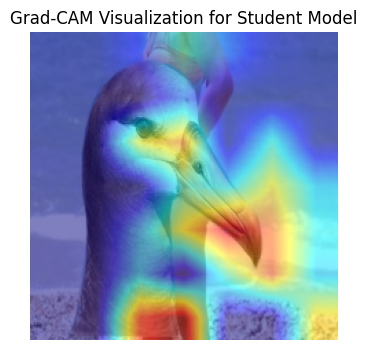

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam_student_model(student_model, data_loader, layer_name='layer4'):
    """
    Apply Grad-CAM to the student model and display the visualization for the first image in the batch.

    Args:
        student_model (nn.Module): Trained student model.
        data_loader (DataLoader): DataLoader for evaluation data.
        layer_name (str): Layer to visualize Grad-CAM.
    """
    student_model.eval()
    target_layer = getattr(student_model, layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer {layer_name} not found in the student model.")

    data_iter = iter(data_loader)
    batch = next(data_iter)

    if len(batch) == 3:
        images, labels, metadata = batch
    elif len(batch) == 2:
        images, labels = batch
    else:
        raise ValueError(f"Unexpected batch format: {len(batch)} outputs.")

    images, labels = images.to(DEVICE), labels.to(DEVICE)

    input_tensor = images[0].unsqueeze(0)
    input_img = input_tensor[0].permute(1, 2, 0).cpu().numpy()
    input_img = np.clip(input_img, 0, 1)

    cam = GradCAM(model=student_model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    visualization = show_cam_on_image(input_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(8, 4))
    plt.imshow(visualization)
    plt.title("Grad-CAM Visualization for Student Model")
    plt.axis("off")
    plt.show()

print("Grad-CAM for Student Model:")
visualize_gradcam_student_model(student_model, test_loader, layer_name='layer4')
